In [1]:
import os

import numpy as np
import scipy.sparse
from scipy.sparse.linalg import eigsh

import netket as nk
from netket.graph import Hypercube
from netket.hilbert import Spin
from netket.operator import LocalOperator, GraphOperator

import matplotlib.pyplot as plt

<Axes: >

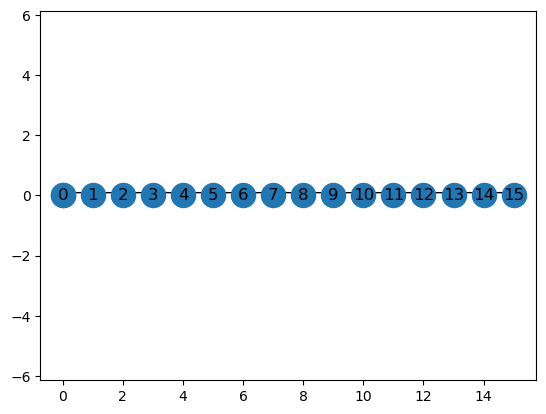

In [2]:
# set system parameters
CHAIN_LENGTH = 16
PERIODIC_BOUNDARIES = False      # pbc gives the graph a slight curve
MARSHALL_SIGN = True

# the marshall sign rule should not affect entanglement. We keep it true just in case we wanna calculate off-diagonal observables later


graph = Hypercube(length=CHAIN_LENGTH, n_dim=1, pbc=PERIODIC_BOUNDARIES)
graph.draw()

In [3]:
# For odd N, we get degenerate ground states with magnetization +0.5 and -0.5.
# Our ED solver (eigsh) may return any linear combination of these states producing complex amplitudes.
# We cannot eliminate degeneracy by restricting total_sz because the Cxx operator changes total magnetization.
hilbert = Spin(s=0.5, N=graph.n_nodes)


def xxz_hamiltonian(hilbert, graph, delta, marshall_sign_rule=True, epsilon=1e-3):

    sx = nk.operator.spin.sigmax
    sy = nk.operator.spin.sigmay
    sz = nk.operator.spin.sigmaz

    # create a local 2-site Hilbert space as 4x4 matrix
    bond_hilbert = Spin(s=0.5, N=2)
    xy_bond_op = sx(bond_hilbert, 0)*sx(bond_hilbert, 1) + sy(bond_hilbert, 0)*sy(bond_hilbert, 1)
    zz_bond_op = sz(bond_hilbert, 0)*sz(bond_hilbert, 1)

    # white and black sublattices are defined by the even or odd number of hops from a starting site
    # flipping XY coupling forces bloch sphere to rotate 180 degrees around Z at black checkerboard sites
    xy_coeff = -delta if marshall_sign_rule else delta
    bond_op = xy_coeff * xy_bond_op + zz_bond_op
    bond_matrix = bond_op.to_dense()

    # broadcast 2-site bond operator to full Hilbert space
    H_xxz = GraphOperator(hilbert, graph=graph, bond_ops=[bond_matrix])

    # to lift degeneracy for odd N systems we add a tiny field
    # this operator contributes only to the main diagonal and does not change matrix sparsity
    H_field = LocalOperator(hilbert, dtype=np.complex128)
    for i in range(graph.n_nodes):
        H_field -= epsilon * sz(hilbert, i)

    return H_xxz + H_field


def get_ground_state(hamiltonian):
    sp_mat = hamiltonian.to_sparse()
    # the 'smallest algebraic' argument tells us to look for the lowest eigenvalue
    # k=1 tells to stop after the first eigenvalue/eigenvector has converged
    vals, vecs = eigsh(sp_mat, k=1, which="SA")

    psi = vecs[:, 0]

    # eigsh may produce an arbitrary global phase. We take the element with the largest magnitude
    # and rotate the entire wavefunction so that this element is real and positive.
    first_idx = np.argmax(np.abs(psi))
    phase = np.angle(psi[first_idx])
    psi = psi * np.exp(-1j * phase)

    return vals[0], psi


#### CHECKING WHETHER THE WF IS REAL AND POSITIVE ####

print(f"{'='*60}")
print(f"HAMILTONIAN ANALYSIS (Delta=1.0, Marshall={MARSHALL_SIGN})")
print(f"Degeneracy broken via tiny field eps=1e-3)")
print(f"{'='*60}")

ham = xxz_hamiltonian(hilbert, graph, delta=1.0, marshall_sign_rule=MARSHALL_SIGN)
E0, psi = get_ground_state(ham)

print(f"Ground State Energy: {E0:.8f}")

nonzero_indices = np.where(np.abs(psi) > 1e-5)[0]
print(f"\nFirst 5 Non-Zero Amplitudes:")
print(f"{'Index':<6} | {'Real Part':<11} | {'Imag Part':<11} | {'Sign'}")
print("-" * 45)
for i in nonzero_indices[:5]:
    val = psi[i]
    sign = "+" if val.real > 0 else "-"
    print(f"{i:<6} | {val.real:+.6f}   | {val.imag:+.6f}   | {sign}")


sp_mat = ham.to_sparse()
off_diag = sp_mat - scipy.sparse.diags(sp_mat.diagonal())
max_off_diag = np.max(off_diag.data.real) if off_diag.nnz > 0 else 0.0

max_imag = np.max(np.abs(psi.imag))
min_real = np.min(psi.real)

is_stoquastic = max_off_diag <= 1e-12
is_real_positive = (max_imag < 1e-10) and (min_real > -1e-10)

print(f"\n{'='*60}")
print(f"PROPERTY SUMMARY")
print(f"{'='*60}")
print(f"1. Hamiltonian Stoquastic?   {str(is_stoquastic).upper():<5} (Max Off-Diag: {max_off_diag:.1e})")
print(f"2. Wavefunction Real?        {str(max_imag < 1e-10).upper():<5} (Max Imag:     {max_imag:.1e})")
print(f"3. Wavefunction Positive?    {str(min_real > -1e-10).upper():<5} (Min Real:     {min_real:.1e})\n")

if is_real_positive and MARSHALL_SIGN:
    print("SUCCESS: The state is Real and Positive. It is valid for our amplitude RBM.")
elif not is_real_positive and MARSHALL_SIGN:
    print("FAILURE: Marshall rule is ON, but state has negative/complex amplitudes.")
elif not MARSHALL_SIGN:
    print("SUCCESS: Physical state generated (Alternating signs expected).")

HAMILTONIAN ANALYSIS (Delta=1.0, Marshall=True)
Degeneracy broken via tiny field eps=1e-3)
Ground State Energy: -27.64694858

First 5 Non-Zero Amplitudes:
Index  | Real Part   | Imag Part   | Sign
---------------------------------------------
2989   | +0.000012   | +0.000000   | +
2997   | +0.000014   | +0.000000   | +
3029   | +0.000014   | +0.000000   | +
3421   | +0.000011   | -0.000000   | +
3435   | +0.000016   | -0.000000   | +

PROPERTY SUMMARY
1. Hamiltonian Stoquastic?   TRUE  (Max Off-Diag: -2.0e+00)
2. Wavefunction Real?        TRUE  (Max Imag:     5.0e-16)
3. Wavefunction Positive?    TRUE  (Min Real:     -2.8e-16)

SUCCESS: The state is Real and Positive. It is valid for our amplitude RBM.


CALCULATING RENYI ENTROPY S2
System: XXZ (Open Chain) with N=16, Marshall Sign Rule = True
Processing Delta = 0.5...
Processing Delta = 1.0...
Processing Delta = 2.0...


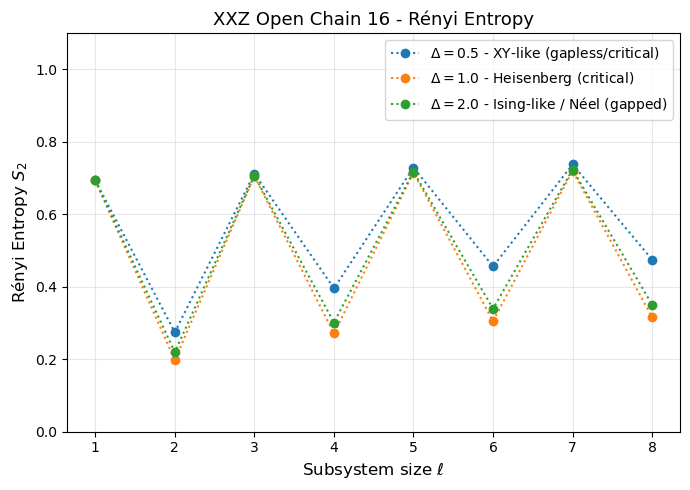

In [5]:
# deltas with optional descriptions to be used in legend labels
DELTA_INFO = {
    0.5: "XY-like (gapless/critical)",
    1.0: "Heisenberg (critical)",
    2.0: "Ising-like / Néel (gapped)",
    #3.0: None,
}

MAX_SUBSYSTEM = graph.n_nodes // 2

model_class = "Ring" if PERIODIC_BOUNDARIES else "Open Chain"



# we take the vanilla approach and calculate S2 via Schmidt decomposition (SVD)
def compute_renyi_entropy_s2(psi, n_total, l_sub):
    dim_sub = 2**l_sub
    dim_env = 2**(n_total - l_sub)

    # reshape the wavefunction into a matrix (Subsystem x Environment)
    # NetKet/Hilbert basis is lexicographic, allowing direct reshaping for block subsystems
    psi_matrix = psi.reshape((dim_sub, dim_env))

    # compute singular values only
    s_vals = np.linalg.svd(psi_matrix, compute_uv=False)

    # the eigenvalues of the reduced density matrix rho_A are s_vals**2
    purity = np.sum(s_vals**4)
    renyi_entropy_s2 = -np.log(np.maximum(purity, 1e-15))
    return renyi_entropy_s2


print(f"{'='*60}")
print("CALCULATING RENYI ENTROPY S2")
print(f"System: XXZ ({model_class}) with N={graph.n_nodes}, Marshall Sign Rule = {MARSHALL_SIGN}")
print(f"{'='*60}")

results = {}
l_axis = list(range(1, MAX_SUBSYSTEM + 1))

for delta, desc in DELTA_INFO.items():
    print(f"Processing Delta = {delta}...")

    # build Hamiltonian and get ground state
    ham = xxz_hamiltonian(hilbert, graph, delta, marshall_sign_rule=MARSHALL_SIGN)
    _, psi = get_ground_state(ham)

    s2_curve = []
    for l in l_axis:
        val = compute_renyi_entropy_s2(psi, graph.n_nodes, l)
        s2_curve.append(val)

    results[delta] = s2_curve


# PLOTTING

plt.figure(figsize=(7, 5), dpi=100)


for delta, desc in DELTA_INFO.items():
    if desc is not None:
        label = rf"$\Delta={delta}$ - {desc}"
    else:
        label = rf"$\Delta={delta}$"
    plt.plot(l_axis, results[delta], marker="o", linestyle=":", label=label)

plt.xlabel(r"Subsystem size $\ell$", fontsize=12)
plt.ylabel(r"Rényi Entropy $S_2$", fontsize=12)
plt.title(f"XXZ {model_class} {graph.n_nodes} - Rényi Entropy", fontsize=13)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(l_axis)
plt.tight_layout()

ax = plt.gca()
ax.set_ylim(0.0, 1.1)

plt.show()

In [45]:
deltas_sorted = sorted(results.keys())
rows = [[delta, *results[delta]] for delta in deltas_sorted]
data = np.array(rows, dtype=float)

l_labels = [f"l{l}" for l in l_axis]
header = ",".join(["delta"] + l_labels)

file_name = f"xxz_{CHAIN_LENGTH}_entropy_ref.csv"  # or graph.n_nodes instead of CHAIN_LENGTH

np.savetxt(file_name, data, delimiter=",", header=header, comments="")
print(f"Saved Rényi entropy reference to: {os.path.abspath(file_name)}")

Saved Rényi entropy reference to: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_consolidate/xxz_ring_16/xxz_16_entropy_ref.csv
